In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)

In [2]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.YlOrRd.copy()
cmap_show_empty.set_bad(color='black')

In [3]:
seed(10)

In [4]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel

        self.values = np.random.rand(n, n) # uniformly distribute the house values between 0 and 1
        choices = np.array([0, 1], dtype = np.int8)
        self.array = np.random.choice(2, (n, n), p = [self.prob_empty, 1 - self.prob_empty]) # randomly choosing which houses are empty, with probability prob_empty
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        average = signal.convolve2d(self.values, self.kernel, boundary='fill', mode='same')/kernel.sum()

        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values, cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam*self.average_neighbors() + grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [5]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        self.affluences = np.random.rand(n,n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        # self.prob_rich = (1 - self.prob_emp)/3
        # self.prob_middle= (1 - self.prob_emp)/3
        # self.prob_poor = (1 - self.prob_emp)/3
        self.size = n

        # limiting this to just two, the zeros here give us empty houses, but I'm not sure this is really necessary since we just swap people's houses anyway.
        # choices = np.array([0, 1], dtype = np.int8)
        # probs = [self.prob_emp, 1 -self.prob_emp]

        # use the numpy routine choice to select the different cells with probability
        # self.array = np.random.choice(choices, (n, n), p = probs)
        # self.array = np.multiply(self.array,grid_houses.array)

        self.affluences = np.multiply(self.affluences,grid_houses.array)

    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(0,self.size)
        j1 = random.randint(0,self.size)
        i2 = random.randint(0,self.size)
        j2 = random.randint(0,self.size)
        #print(i1,j1,i2,j2)
        if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
            if (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2]) **2> (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2:
                #a1 = self.array[i1][j1]
                b1 = self.affluences[i1][j1]
                #self.array[i1][j1] = self.array[i2][j2]
                self.affluences[i1][j1] = self.affluences[i2][j2]
                #self.array[i2][j2] = a1
                self.affluences[i2][j2] = b1



In [6]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 0, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

In [7]:
grid_houses1 = grid_houses(50,.1, kernel)
grid_agents1 = grid_agents(50, 0.1, grid_houses1)

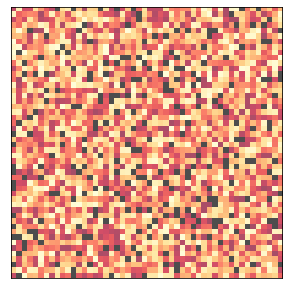

In [8]:
grid_agents1.draw_affluences()

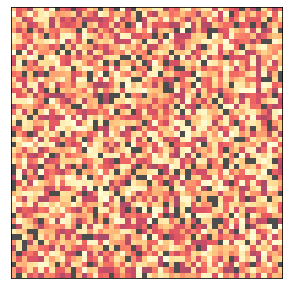

In [9]:
grid_houses1.draw_values()

## Running the code (100,000 times)

In [10]:
for i in range(100000):
    grid_houses1.update_values(grid_agents1, 1/3)
    grid_agents1.swap_people(grid_houses1)

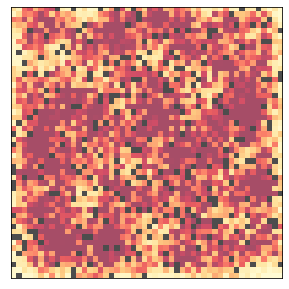

In [11]:
grid_houses1.draw_values()

The poorer are going to the edges, due to how we defined our averaging function (boundary = 'fill'), so this probably needs to be changed.